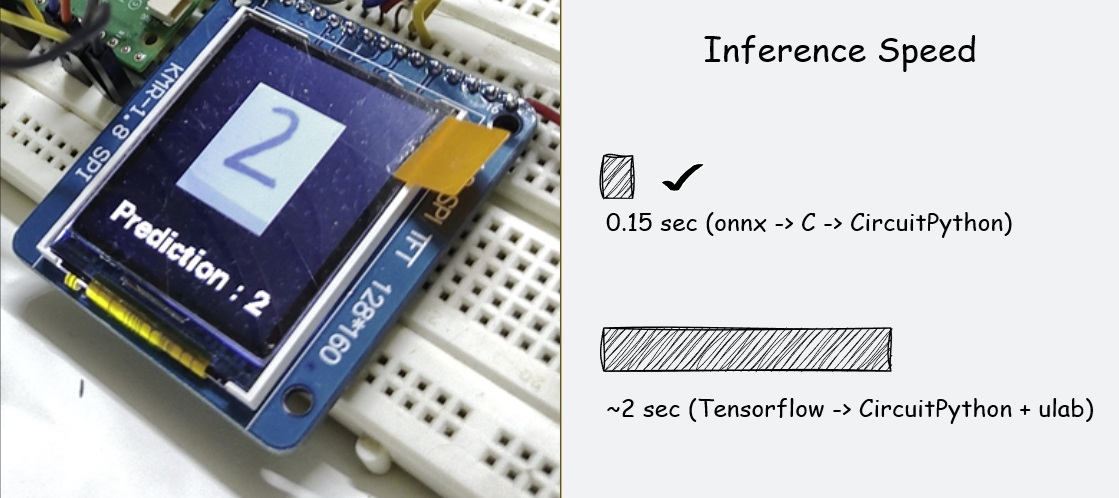


This notebook trains a very tiny convolutional neural network on the MNIST dataset and helps generate onnx file from trained model. We then use this file to generate CircuitPython compatible library that can be used to perform inference on a microcontroller. Checkout the [article on my website](https://ashishware.com/2026/01/10/cnn_circuitpython/) which had detailed explanation on how this works. It should also help you train your own neural networks and port them to CircuitPython.

If you are curious as to why CircuitPython (and not TFLite), please [read this article](https://ashishware.com/2024/06/23/circuit_python_why/). 

## Loading the dataset

> Note: We resize images to 30x30. Larger image means more data and less noise. Very helpful when working with cameras

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_images = tf.image.resize(train_images, [30, 30])
test_images = tf.image.resize(test_images, [30, 30])

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)


## Creating a lightweight CNN

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(30, 30, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(2, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
model.summary()

Keep training till you get desired accuracy. Feel free to experiment by modifying parameters and epochs in below code

In [ ]:
history = model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)



plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
!pip install tf2onnx onnx

### Convert model to onnx

In [ ]:
import tf2onnx
import tensorflow as tf

model.output_names=['output']

spec = (
    tf.TensorSpec((None, 30, 30, 1), tf.float32, name="input"),
)

tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13,
    output_path="cnn_model.onnx"
)

In [ ]:
!ls

Done ! Download and copy the `cnn_model.onnx` file to your CircuitPython board. Please make sure that you use CircuitPython 8